<a href="https://colab.research.google.com/github/jsemer/fibertree-graphs/blob/main/gunrock_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph scheduling

This notebook is for exploring the scheduling of graph processing algorithms especially schedules implemented by Gunrock.

In [13]:
# Begin - startup boilerplate code

import pkgutil

if 'fibertree_bootstrap' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet

# End - startup boilerplate code

from fibertree_bootstrap import *
fibertree_bootstrap(style="tree", animation="movie")

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

## Create a graph described by an adjacency matrix

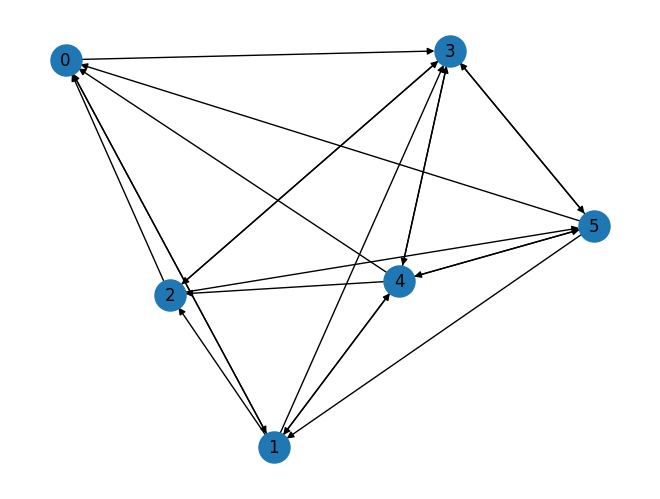

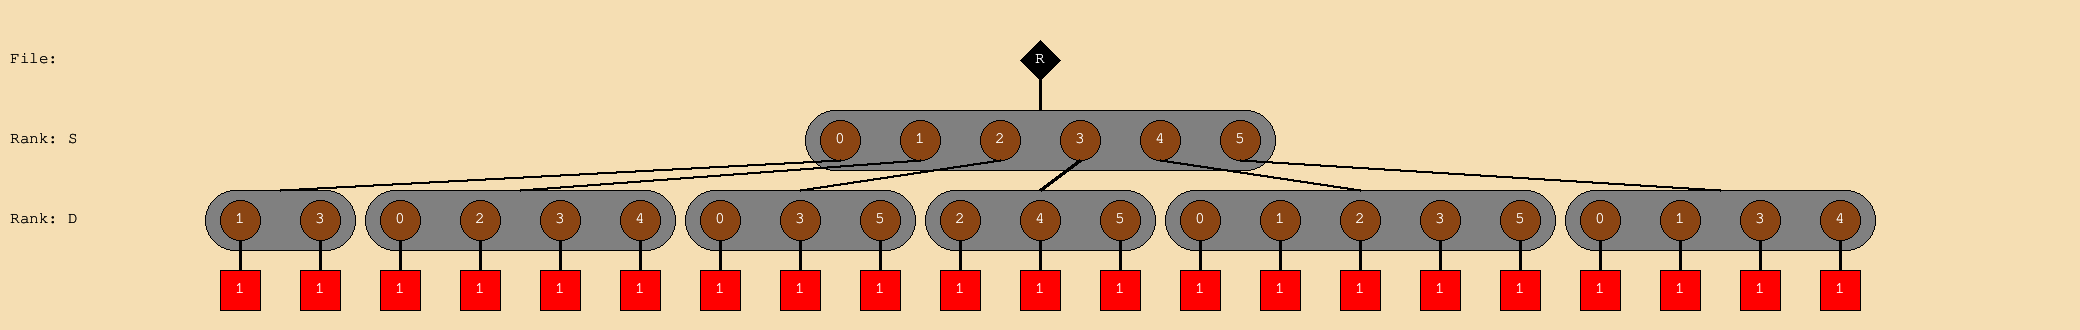

In [14]:
adj_matrix = [ [ 0, 1, 0, 1, 0, 0 ],
              [ 1, 0, 1, 1, 1, 0],
              [ 1, 0, 0, 1, 0, 1],
              [ 0, 0, 1, 0, 1, 1],
              [ 1, 1, 1, 1, 0, 1],
             [ 1, 1, 0, 1, 1, 0]]
g = Tensor.fromUncompressed(["S", "D"], adj_matrix)
displayGraph(g)
displayTensor(g)

## Create a frontier

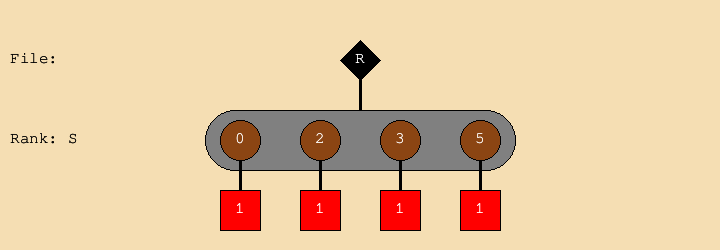

In [15]:
f = Tensor.fromUncompressed(["S"], [1, 0, 1, 1, 0, 1])
displayTensor(f)

## Perform an "advance"

Essentially equivalent to the Einsum: $Z_d = G_{s,d} \times F_s$

In [16]:
z = Tensor(rank_ids=["D"])

g_s = g.getRoot()
f_s = f.getRoot()
z_d = z.getRoot()

task_id = 0
for s, (g_d, f_val) in g_s & f_s:
    for d, (z_ref, g_val) in z_d << g_d:
        print(f"Task {task_id}: s:{s}, d:{d}")
        z_ref <<= 1
        task_id += 1

Task 0: s:0, d:1
Task 1: s:0, d:3
Task 2: s:2, d:0
Task 3: s:2, d:3
Task 4: s:2, d:5
Task 5: s:3, d:2
Task 6: s:3, d:4
Task 7: s:3, d:5
Task 8: s:5, d:0
Task 9: s:5, d:1
Task 10: s:5, d:3
Task 11: s:5, d:4


## Create "advance" tasks

Run an "advance" function creating a tensor holding the "task list" for the computation

Task 0: s:0, d:1
Task 1: s:0, d:3
Task 2: s:2, d:0
Task 3: s:2, d:3
Task 4: s:2, d:5
Task 5: s:3, d:2
Task 6: s:3, d:4
Task 7: s:3, d:5
Task 8: s:5, d:0
Task 9: s:5, d:1
Task 10: s:5, d:3
Task 11: s:5, d:4


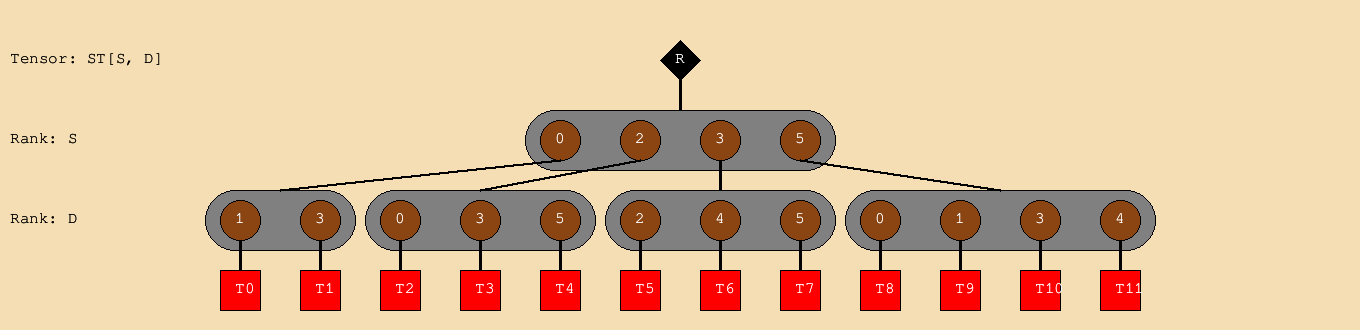

In [17]:
# Visualize the space time aspects
ST = Tensor(name="ST", rank_ids=["S", "D"])

g_s = g.getRoot()
f_s = f.getRoot()
z_s = ST.getRoot()

task_id = 0
for s, (z_d, (g_d, f_val)) in z_s << (g_s & f_s):
    for d, (z_ref, g_val) in z_d << g_d:
        print(f"Task {task_id}: s:{s}, d:{d}")
        z_ref <<= f"T{task_id}"
        task_id += 1

displayTensor(ST)

## Create a schedule

Modify the "task tensor" for form a schedule

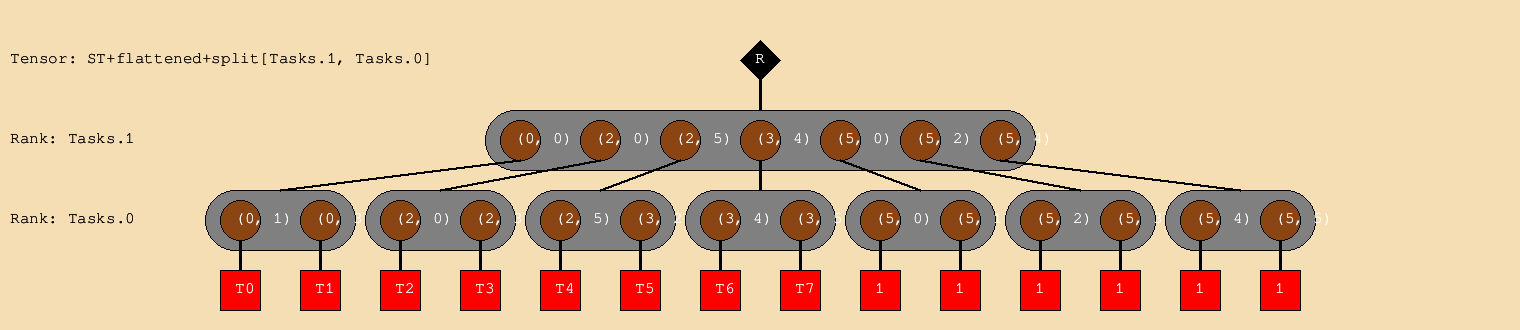

In [20]:
st_flat = ST.flattenRanks()

st_flat.setRankIds(["Tasks"] )   # Hack to allow `split()` to modify the rank name
st_sched = st_flat.splitEqual(2)

# Currently, the next line may crash due to a bug displaying "tuple" coordinates
displayTensor(st_sched)

In [21]:
sched_top = st_sched.getRoot()

g_s = g.getRoot()
f_s = f.getRoot()

w = Tensor(rank_ids=["D"])
w_d = w.getRoot()

canvas = createCanvas(f, g, z)
cycle = 0

for top, task_group in sched_top:
  for pe, ((s, d), _) in enumerate(task_group):
    g_val = g_s.getPayload(s, d)
    f_val = f_s.getPayload(s)
    z_ref = z_d.getPayloadRef(d)
    z_ref <<= g_val * f_val

    canvas.addActivity((s,), (s, d), (d,), spacetime=(pe, cycle ) )

  cycle += 1



displayCanvas(canvas)